In [3]:
import os
import tempfile
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Markdown, display, HTML
from dotenv import load_dotenv
import pandas as pd

# AGNO imports
from agno.agent import Agent
from agno.media import Image
from agno.models.google import Gemini
from agno.tools.reasoning import ReasoningTools

In [4]:
# Load environment variables 
load_dotenv()

# Verify API key is available
if not os.environ.get("GOOGLE_API_KEY"):
    print("⚠️ Warning: GOOGLE_API_KEY not found in environment variables.")
    print("Please set your API key using: os.environ['GOOGLE_API_KEY'] = 'your-api-key'")

In [5]:
# Custom styling for displaying energy ratings and severity indicators
def get_custom_styles():
    return """
    <style>
        /* Energy rating badges */
        .energy-rating {
            font: bold 48px sans-serif;
            color: white;
            width: 80px;
            height: 80px;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            margin-bottom: 10px;
        }
        
        /* Rating colors - more muted palette */
        .rating-A {background-color: #2c6e49;}
        .rating-B {background-color: #4d9355;}
        .rating-C {background-color: #6f9b45;}
        .rating-D {background-color: #9b9b45;}
        .rating-E {background-color: #9b7f45;}
        .rating-F {background-color: #9b6245;}
        .rating-G {background-color: #9b4545;}
        
        /* Severity indicators */
        .severity-minor, .severity-moderate, .severity-severe {
            font-weight: bold;
        }
        .severity-minor {color: #6f9b45;}
        .severity-moderate {color: #9b7f45;}
        .severity-severe {color: #9b4545;}
        
        /* Utility classes */
        .savings-tag {
            background-color: rgba(230, 242, 255, 0.1);
            color: #81a4cd;
            padding: 2px 8px;
            border-radius: 4px;
            font-weight: bold;
        }
        .info-box {
            background-color: rgba(248, 249, 250, 0.1);
            border-radius: 8px;
            padding: 20px;
            margin-bottom: 20px;
            border-left: 5px solid #2c6e49;
        }
    </style>
    """

# Apply custom styling
HTML(get_custom_styles())

In [6]:
# Function to render a severity label with appropriate styling
def render_severity(severity):
    if severity.lower() == "minor":
        return f'<span class="severity-minor">MINOR</span>'
    elif severity.lower() == "moderate":
        return f'<span class="severity-moderate">MODERATE</span>'
    elif severity.lower() == "severe":
        return f'<span class="severity-severe">SEVERE</span>'
    return severity

# Function to render an energy rating badge
def render_energy_rating(rating):
    return f'<div class="energy-rating rating-{rating}">{rating}</div>'

# Function to extract severity from text
def extract_severity(text):
    text = text.lower()
    if "minor" in text:
        return "minor"
    elif "moderate" in text:
        return "moderate"
    elif "severe" in text:
        return "severe"
    return "unknown"

# Function to get agent analysis results
def get_agent_analysis(agent, prompt, images=None):
    """Use agent to analyze images and return response content as string"""
    try:
        response = agent.run(prompt, images=images)

        # Check if response is None
        if response is None:
            return None

        # Extract the content from RunResponse object
        if hasattr(response, "content") and response.content is not None:
            return response.content
        elif isinstance(response, str):
            return response
        else:
            # Convert the response object to string if none of the above work
            return str(response)
    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None

In [7]:
# Setup the analysis agent with Google Gemini
def get_analysis_agent():
    return Agent(
        model=Gemini(id="gemini-2.5-flash-preview-04-17"),
        agent_id="energy-analysis",
        name="Energy Analysis Agent",
        tools=[ReasoningTools()],
        instructions=[
            "You are an AI agent that analyzes RGB and thermal image pairs to identify energy efficiency issues",
            "Identify thermal anomalies, insulation problems, air leaks, and moisture issues",
            "Provide detailed findings with severity ratings (minor/moderate/severe)",
            "Generate practical recommendations with estimated costs",
            "Format findings in clear, understandable markdown language",
        ],
        markdown=True,
        debug_mode=True,
    )

def get_report_agent():
    return Agent(
        model=Gemini(id="gemini-2.5-flash-preview-04-17"),
        agent_id="energy-report",
        name="Energy Report Agent",
        tools=[ReasoningTools()],
        instructions=[
            "You are an AI agent that generates comprehensive energy efficiency reports",
            "Analyze the findings from multiple image pair analyses",
            "Provide an executive summary and EU Energy Rating (A-G)",
            "Generate priority recommendations with costs and savings",
            "Provide a conclusion with potential rating improvements",
        ],
        markdown=True,
        debug_mode=True,
    )

# Initialize the agents
analysis_agent = get_analysis_agent()
report_agent = get_report_agent()

In [8]:
# Building information
building_year = 1980
building_type = "Residential"
location = "Helsinki"

# Display building information
building_info = pd.DataFrame({
    'Property': ['Construction Year', 'Building Type', 'Location'],
    'Value': [building_year, building_type, location]
})
building_info

,Property,Value
0,Construction Year,1980
1,Building Type,Residential
2,Location,Helsinki


✅ Found example images at specified paths.


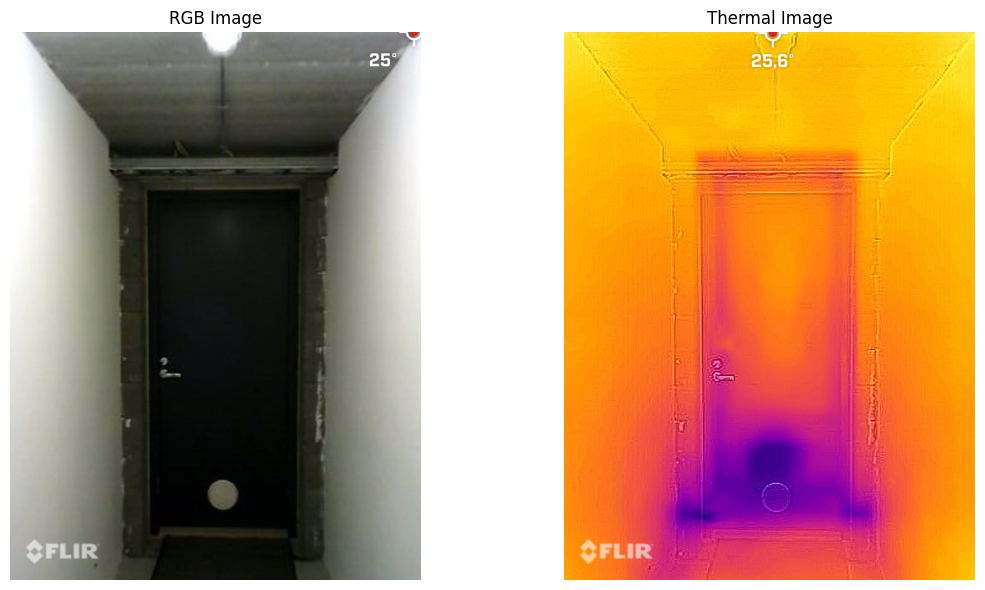

In [9]:
# Path to example images
rgb_image_path = "../images/basement_door/rgb.jpg"
thermal_image_path = "../images/basement_door/thermal.jpg"

# Check if files exist
if not os.path.exists(rgb_image_path) or not os.path.exists(thermal_image_path):
    print(f"⚠️ Warning: Example images not found at the specified paths.")
    print(f"RGB image path: {rgb_image_path}")
    print(f"Thermal image path: {thermal_image_path}")
    print("Please update the paths to your actual image locations.")
else:
    print(f"✅ Found example images at specified paths.")

# Display the images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(plt.imread(rgb_image_path))
axes[0].set_title("RGB Image")
axes[0].axis("off")

axes[1].imshow(plt.imread(thermal_image_path))
axes[1].set_title("Thermal Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [10]:
# Create Image objects from file paths
rgb_image = Image(filepath=Path(rgb_image_path))
thermal_image = Image(filepath=Path(thermal_image_path))

# Create prompt for analysis
analysis_prompt = f"""
Analyze this RGB-thermal image pair for energy efficiency issues:

Building Info:
- Year: {building_year}
- Type: {building_type}
- Location: {location}

Identify anomalies, severity (minor/moderate/severe), recommendations, and cost estimates.
Format your response in this structure:

## Summary
[Brief summary of findings]

## Thermal Anomalies

### Anomaly 1
- Location: [where the issue is]
- Severity: [minor/moderate/severe]
- Description: [detailed description]
- Temperature Difference: [if available]

### Anomaly 2
...

## Recommendations

### Recommendation 1
- Title: [clear title]
- Description: [detailed explanation]
- Estimated Cost: [cost range]
- Estimated Savings: [annual savings]
- Priority: [low/medium/high]
- Implementation Time: [time estimate]

### Recommendation 2
...
"""

print("Analyzing image pair...")
analysis_result = get_agent_analysis(analysis_agent, analysis_prompt, images=[rgb_image, thermal_image])

# Store analysis for later use
image_analyses = []
if analysis_result:
    image_analyses.append(analysis_result)
    display(Markdown("## Analysis Results"))
    display(Markdown(analysis_result))
else:
    print("❌ Analysis failed.")

Analyzing image pair...


DEBUG **************** Agent ID: energy-analysis *****************

DEBUG ***** Session ID: 3c98c486-48a1-4fcc-939c-1acd5ffbd6b3 *****

DEBUG ** Agent Run Start: e2930f83-f6f6-4466-8592-ca16b41807ef ***

DEBUG Processing tools for model

DEBUG Added function think from reasoning_tools

DEBUG Added function analyze from reasoning_tools

DEBUG ------------------ Google Response Start -------------------

DEBUG ---------- Model: gemini-2.5-flash-preview-04-17 -----------

DEBUG ========================== system ==========================

DEBUG <instructions>                                                                                               
      - You are an AI agent that analyzes RGB and thermal image pairs to identify energy efficiency issues         
      - Identify thermal anomalies, insulation problems, air leaks, and moisture issues                            
      - Provide detailed findings with severity ratings (minor/moderate/severe)                                    
      - Generate practical recommendations with estimated costs                                                    
      - Format findings in clear, understandable markdown language                                                 
      </instructions>                                                                                              
                                                                                                                   
      <additional_information>                                                                                     
      - Use markdown to format your answers.                                                                       
      </additional_information>

DEBUG =========================== user ===========================

DEBUG                                                                                                              
      Analyze this RGB-thermal image pair for energy efficiency issues:                                            
                                                                                                                   
      Building Info:                                                                                               
      - Year: 1980                                                                                                 
      - Type: Residential                                                                                          
      - Location: Helsinki                                                                                         
                                                                                                                   
      Identify anomalies, severity (minor/moderate/severe), recommendations, and cost estimates.                   
      Format your response in this structure:                                                                      
                                                                                                                   
      ## Summary                                                                                                   
      [Brief summary of findings]                                                                                  
                                                                                                                   
      ## Thermal Anomalies                                                                                         
                                                                                                                   
      ### Anomaly 1                                                                                                
      - Location: [where the issue is]                                                                             
      - Severity: [minor/moderate/severe]                                                                          
      - Description: [detailed description]                                                                        
      - Temperature Difference: [if available]                                                                     
                                                                                                                   
      ### Anomaly 2                                                                                                
      ...                                                                                                          
                                                                                                                   
      ## Recommendations                                                                                           
                                                                                                                   
      ### Recommendation 1                                                                                         
      - Title: [clear title]                                                                                       
      - Description: [detailed explanation]                                                                        
      - Estimated Cost: [cost range]                                                                               
      - Estimated Savings: [annual savings]                                                                        
      - Priority: [low/medium/high]                                                                                
      - Implementation Time: [time estimate]                                                                       
                                                        

DEBUG Images added: 2

DEBUG ======================== assistant =========================

DEBUG Tool Calls:                                                                                                  
          Name: 'think'                                                                                            
          Arguments: 'confidence: 0.95, thought: Analyzing the thermal image, I observe significant cold areas     
      (indicated by purple/dark blue colors) around the perimeter of the door, specifically at the bottom, sides,  
      and top. The concrete lintel above the door also appears cooler than the wall. The door panel itself is      
      relatively uniform in temperature but is surrounded by these colder zones. This strongly suggests air leakage
      and/or poor insulation around the door frame., action: Identify specific anomaly locations and severity.,    
      title: Analyzing Thermal Image for Anomalies'

DEBUG ************************  METRICS  *************************

DEBUG * Tokens:                      input=1153, output=121, total=1645

DEBUG * Time:                        4.3270s

DEBUG * Tokens per second:           27.9637 tokens/s

DEBUG ************************  METRICS  *************************

DEBUG Getting function think

DEBUG Running: think(confidence=0.95, thought=..., action=..., title=...)

DEBUG Thought about Analyzing Thermal Image for Anomalies

DEBUG =========================== tool ===========================

DEBUG Step 1:                                                                                                      
      Title: Analyzing Thermal Image for Anomalies                                                                 
      Reasoning: Analyzing the thermal image, I observe significant cold areas (indicated by purple/dark blue      
      colors) around the perimeter of the door, specifically at the bottom, sides, and top. The concrete lintel    
      above the door also appears cooler than the wall. The door panel itself is relatively uniform in temperature 
      but is surrounded by these colder zones. This strongly suggests air leakage and/or poor insulation around the
      door frame.                                                                                                  
      Action: Identify specific anomaly locations and severity.                                                    
      Confidence: 0.95

DEBUG **********************  TOOL METRICS  **********************

DEBUG * Time:                        0.0037s

DEBUG **********************  TOOL METRICS  **********************

DEBUG ======================== assistant =========================

DEBUG Tool Calls:                                                                                                  
          Name: 'analyze'                                                                                          
          Arguments: 'confidence: 0.95, result: Identified cold areas around door frame and lintel., title:        
      Determining Anomaly Severity, analysis: The thermal image clearly shows significant cold spots around the    
      door frame and above the door, indicating air leaks and potential insulation issues. The severity appears    
      moderate to severe due to the noticeable temperature differences and the extent of the affected areas.,      
      next_action: continue'

DEBUG ************************  METRICS  *************************

DEBUG * Tokens:                      input=1404, output=94, total=1670

DEBUG * Time:                        2.2207s

DEBUG * Tokens per second:           42.3292 tokens/s

DEBUG ************************  METRICS  *************************

DEBUG Getting function analyze

DEBUG Running: analyze(...)

DEBUG Analyzed Determining Anomaly Severity

DEBUG =========================== tool ===========================

DEBUG Step 1:                                                                                                      
      Title: Analyzing Thermal Image for Anomalies                                                                 
      Reasoning: Analyzing the thermal image, I observe significant cold areas (indicated by purple/dark blue      
      colors) around the perimeter of the door, specifically at the bottom, sides, and top. The concrete lintel    
      above the door also appears cooler than the wall. The door panel itself is relatively uniform in temperature 
      but is surrounded by these colder zones. This strongly suggests air leakage and/or poor insulation around the
      door frame.                                                                                                  
      Action: Identify specific anomaly locations and severity.                                                    
      Confidence: 0.95                                                                                             
                                                                                                                   
      Step 2:                                                                                                      
      Title: Determining Anomaly Severity                                                                          
      Reasoning: The thermal image clearly shows significant cold spots around the door frame and above the door,  
      indicating air leaks and potential insulation issues. The severity appears moderate to severe due to the     
      noticeable temperature differences and the extent of the affected areas.                                     
      Action: None                                                                                                 
      Confidence: 0.95

DEBUG **********************  TOOL METRICS  **********************

DEBUG * Time:                        0.0039s

DEBUG **********************  TOOL METRICS  **********************

DEBUG ======================== assistant =========================

DEBUG ## Summary                                                                                                   
      The thermal analysis of the entrance door area in this 1980 residential building in Helsinki reveals         
      significant energy efficiency issues primarily related to air leakage and potential insulation deficiencies  
      around the door frame and the concrete lintel above the door. These issues are causing noticeable heat loss  
      and cold drafts, impacting comfort and increasing energy consumption.                                        
                                                                                                                   
      ## Thermal Anomalies                                                                                         
                                                                                                                   
      ### Anomaly 1                                                                                                
      - Location: Around the door frame (sides, bottom, and top)                                                   
      - Severity: Severe                                                                                           
      - Description: The thermal image shows significantly lower temperatures (indicated by purple/dark blue       
      colors) around the entire perimeter of the door frame where it meets the wall. This pattern is indicative of 
      severe air leakage, where cold outside air is infiltrating the building and/or warm inside air is escaping.  
      - Temperature Difference: Not precisely quantifiable without a temperature scale, but the distinct color     
      difference from surrounding areas suggests a significant temperature variation.                              
                                                                                                                   
      ### Anomaly 2                                                                                                
      - Location: Concrete lintel above the door                                                                   
      - Severity: Moderate                                                                                         
      - Description: The concrete lintel area above the door appears cooler than the adjacent wall sections in the 
      thermal image. Concrete is a poor insulator, and this temperature difference suggests either insufficient    
      insulation above the lintel or a thermal bridge causing heat loss through the structure.                     
                                                                                                                   
      ## Recommendations                                                                                           
                                                                                                                   
      ### Recommendation 1                                                                                         
      - Title: Seal Air Gaps Around Door Frame                                                                     
      - Description: Apply high-quality, flexible caulk to seal small gaps between the door frame and the wall. For
      larger gaps (e.g., >5mm), use minimal-expanding spray foam before caulking. Ensure all cracks and openings   
      around the frame are sealed to prevent air infiltration.                                                     
      - Estimated Cost: €50 - €200                                                                                 
      - Estimated Savings: Moderate (€50 - €150 annually, depending on existing leak severity and energy costs)    
      - Priority: High                                                                                             
      - Implementation Time: Low (1-3 hours)            

DEBUG ************************  METRICS  *************************

DEBUG * Tokens:                      input=1706, output=704, total=3162

DEBUG * Time:                        10.6377s

DEBUG * Tokens per second:           66.1798 tokens/s

DEBUG ************************  METRICS  *************************

DEBUG ------------------- Google Response End --------------------

DEBUG Added RunResponse to Memory

DEBUG Logging Agent Run

DEBUG *** Agent Run End: e2930f83-f6f6-4466-8592-ca16b41807ef ****

## Analysis Results

## Summary
The thermal analysis of the entrance door area in this 1980 residential building in Helsinki reveals significant energy efficiency issues primarily related to air leakage and potential insulation deficiencies around the door frame and the concrete lintel above the door. These issues are causing noticeable heat loss and cold drafts, impacting comfort and increasing energy consumption.

## Thermal Anomalies

### Anomaly 1
- Location: Around the door frame (sides, bottom, and top)
- Severity: Severe
- Description: The thermal image shows significantly lower temperatures (indicated by purple/dark blue colors) around the entire perimeter of the door frame where it meets the wall. This pattern is indicative of severe air leakage, where cold outside air is infiltrating the building and/or warm inside air is escaping.
- Temperature Difference: Not precisely quantifiable without a temperature scale, but the distinct color difference from surrounding areas suggests a significant temperature variation.

### Anomaly 2
- Location: Concrete lintel above the door
- Severity: Moderate
- Description: The concrete lintel area above the door appears cooler than the adjacent wall sections in the thermal image. Concrete is a poor insulator, and this temperature difference suggests either insufficient insulation above the lintel or a thermal bridge causing heat loss through the structure.

## Recommendations

### Recommendation 1
- Title: Seal Air Gaps Around Door Frame
- Description: Apply high-quality, flexible caulk to seal small gaps between the door frame and the wall. For larger gaps (e.g., >5mm), use minimal-expanding spray foam before caulking. Ensure all cracks and openings around the frame are sealed to prevent air infiltration.
- Estimated Cost: €50 - €200
- Estimated Savings: Moderate (€50 - €150 annually, depending on existing leak severity and energy costs)
- Priority: High
- Implementation Time: Low (1-3 hours)

### Recommendation 2
- Title: Improve Door Weatherstripping
- Description: Inspect the existing weatherstripping around the door slab. If it is damaged, brittle, or missing, replace it with new, high-quality weatherstripping (e.g., foam tape, V-strip, or compression-type seals) along the top, sides, and bottom of the door. A door sweep or draft stopper can also be added to the bottom.
- Estimated Cost: €30 - €150
- Estimated Savings: Moderate (€40 - €120 annually, depending on existing draft severity)
- Priority: High
- Implementation Time: Low (1-2 hours)

### Recommendation 3
- Title: Assess and Improve Lintel Insulation
- Description: Investigate the area above the door, specifically around the concrete lintel, to determine the current state of insulation. If access allows and insulation is found to be missing or inadequate, adding appropriate insulation in this area can help reduce heat loss through the thermal bridge. This may require opening up the wall structure.
- Estimated Cost: Moderate to High (€300 - €1500+, depending on required access and complexity of work)
- Estimated Savings: Moderate to High (€60 - €200+ annually, depending on effectiveness and energy costs)
- Priority: Medium
- Implementation Time: Moderate (can range from a few hours to a day or more if structural work is needed)

In [11]:
if image_analyses:
    # Join all analyses for the prompt
    analyses_text = "\n\n".join(image_analyses)

    final_prompt = f"""
    Generate a comprehensive energy efficiency report:
    - Year: {building_year}
    - Type: {building_type}
    - Location: {location}
    - Date: {datetime.now():%B %d, %Y}

    Based on the following analyses:
    {analyses_text}

    Create a structured report with:
    
    # Energy Efficiency Report
    
    ## Executive Summary
    [Concise summary of findings and recommendations]
    
    ## Energy Rating
    [Assign an EU Energy Rating from A to G based on findings]
    
    ## Main Findings
    - [Finding 1]
    - [Finding 2]
    ...
    
    ## Priority Recommendations
    
    ### Recommendation 1
    - Title: [clear title]
    - Description: [detailed explanation]
    - Estimated Cost: [cost range]
    - Estimated Savings: [annual savings]
    - Priority: [low/medium/high]
    - Implementation Time: [time estimate]
    
    ### Recommendation 2
    ...
    
    ## Potential Improvements
    - Current Rating: [current rating]
    - Potential Rating: [improved rating after recommendations]
    
    ## Financial Summary
    - Total Investment: [sum of all recommendations]
    - Annual Savings: [total annual savings]
    
    ## Conclusion
    [Final assessment and next steps]
    """

    print("Generating final report...")
    final_report = get_agent_analysis(report_agent, final_prompt)

    if final_report:
        # Extract energy rating from the report
        energy_rating = "D"  # Default value
        for line in final_report.split("\n"):
            if "Energy Rating" in line and ":" in line:
                rating_text = line.split(":")[-1].strip()
                if rating_text and rating_text[0] in "ABCDEFG":
                    energy_rating = rating_text[0]
                break
                
        # Display energy rating
        display(HTML(render_energy_rating(energy_rating)))
        
        # Display the report
        display(Markdown("# Energy Efficiency Report"))
        display(Markdown(f"### {building_type} in {location}, built {building_year}"))
        display(Markdown(f"Generated on {datetime.now():%B %d, %Y}"))
        display(Markdown(final_report))
        
        # Save report to file
        report_filename = f"energy_report_{location}_{datetime.now():%Y%m%d}.md"
        with open(report_filename, "w") as f:
            f.write(final_report)
        print(f"✅ Report saved to {report_filename}")
    else:
        print("❌ Report generation failed.")
else:
    print("⚠️ No analyses available to generate a report.")

Generating final report...


DEBUG ***************** Agent ID: energy-report ******************

DEBUG ***** Session ID: a0f2a700-1967-48f8-a9dc-1698f24f8521 *****

DEBUG ** Agent Run Start: 2ff887e8-e188-4368-84cd-e538a647b1e6 ***

DEBUG Processing tools for model

DEBUG Added function think from reasoning_tools

DEBUG Added function analyze from reasoning_tools

DEBUG ------------------ Google Response Start -------------------

DEBUG ---------- Model: gemini-2.5-flash-preview-04-17 -----------

DEBUG ========================== system ==========================

DEBUG <instructions>                                                                                               
      - You are an AI agent that generates comprehensive energy efficiency reports                                 
      - Analyze the findings from multiple image pair analyses                                                     
      - Provide an executive summary and EU Energy Rating (A-G)                                                    
      - Generate priority recommendations with costs and savings                                                   
      - Provide a conclusion with potential rating improvements                                                    
      </instructions>                                                                                              
                                                                                                                   
      <additional_information>                                                                                     
      - Use markdown to format your answers.                                                                       
      </additional_information>

DEBUG =========================== user ===========================

DEBUG                                                                                                              
          Generate a comprehensive energy efficiency report:                                                       
          - Year: 1980                                                                                             
          - Type: Residential                                                                                      
          - Location: Helsinki                                                                                     
          - Date: May 03, 2025                                                                                     
                                                                                                                   
          Based on the following analyses:                                                                         
          ## Summary                                                                                               
      The thermal analysis of the entrance door area in this 1980 residential building in Helsinki reveals         
      significant energy efficiency issues primarily related to air leakage and potential insulation deficiencies  
      around the door frame and the concrete lintel above the door. These issues are causing noticeable heat loss  
      and cold drafts, impacting comfort and increasing energy consumption.                                        
                                                                                                                   
      ## Thermal Anomalies                                                                                         
                                                                                                                   
      ### Anomaly 1                                                                                                
      - Location: Around the door frame (sides, bottom, and top)                                                   
      - Severity: Severe                                                                                           
      - Description: The thermal image shows significantly lower temperatures (indicated by purple/dark blue       
      colors) around the entire perimeter of the door frame where it meets the wall. This pattern is indicative of 
      severe air leakage, where cold outside air is infiltrating the building and/or warm inside air is escaping.  
      - Temperature Difference: Not precisely quantifiable without a temperature scale, but the distinct color     
      difference from surrounding areas suggests a significant temperature variation.                              
                                                                                                                   
      ### Anomaly 2                                                                                                
      - Location: Concrete lintel above the door                                                                   
      - Severity: Moderate                                                                                         
      - Description: The concrete lintel area above the door appears cooler than the adjacent wall sections in the 
      thermal image. Concrete is a poor insulator, and this temperature difference suggests either insufficient    
      insulation above the lintel or a thermal bridge causing heat loss through the structure.                     
                                                                                                                   
      ## Recommendations                                                                                           
                                                                                                                   
      ### Recommendation 1                              

DEBUG ======================== assistant =========================

DEBUG Tool Calls:                                                                                                  
          Name: 'analyze'                                                                                          
          Arguments: 'next_action: continue, title: Plan Report Generation, result: Parsed user request and        
      extracted all necessary information for report generation., analysis: The user wants a structured energy     
      efficiency report based on the provided analysis. I need to assemble the report following the user's         
      template, incorporating the findings and recommendations. I will calculate the financial summary based on the
      provided cost and savings ranges and assign an appropriate initial and potential EU energy rating.'

DEBUG ************************  METRICS  *************************

DEBUG * Tokens:                      input=1412, output=98, total=2217

DEBUG * Time:                        5.6289s

DEBUG * Tokens per second:           17.4103 tokens/s

DEBUG ************************  METRICS  *************************

DEBUG Getting function analyze

DEBUG Running: analyze(...)

DEBUG Analyzed Plan Report Generation

DEBUG =========================== tool ===========================

DEBUG Step 1:                                                                                                      
      Title: Plan Report Generation                                                                                
      Reasoning: The user wants a structured energy efficiency report based on the provided analysis. I need to    
      assemble the report following the user's template, incorporating the findings and recommendations. I will    
      calculate the financial summary based on the provided cost and savings ranges and assign an appropriate      
      initial and potential EU energy rating.                                                                      
      Action: None                                                                                                 
      Confidence: 0.8

DEBUG **********************  TOOL METRICS  **********************

DEBUG * Time:                        0.0037s

DEBUG **********************  TOOL METRICS  **********************

DEBUG ======================== assistant =========================

DEBUG Tool Calls:                                                                                                  
          Name: 'analyze'                                                                                          
          Arguments: 'result: Ready to generate the report., title: Finalizing Report Details, analysis: I have    
      parsed the user request and the provided analysis details, thermal anomalies, and recommendations. I have    
      estimated the current and potential energy ratings and calculated the ranges for the total investment and    
      annual savings. I am ready to generate the final report., next_action: final_answer'

DEBUG ************************  METRICS  *************************

DEBUG * Tokens:                      input=1607, output=85, total=2545

DEBUG * Time:                        5.4265s

DEBUG * Tokens per second:           15.6638 tokens/s

DEBUG ************************  METRICS  *************************

DEBUG Getting function analyze

DEBUG Running: analyze(...)

DEBUG Analyzed Finalizing Report Details

DEBUG =========================== tool ===========================

DEBUG Step 1:                                                                                                      
      Title: Plan Report Generation                                                                                
      Reasoning: The user wants a structured energy efficiency report based on the provided analysis. I need to    
      assemble the report following the user's template, incorporating the findings and recommendations. I will    
      calculate the financial summary based on the provided cost and savings ranges and assign an appropriate      
      initial and potential EU energy rating.                                                                      
      Action: None                                                                                                 
      Confidence: 0.8                                                                                              
                                                                                                                   
      Step 2:                                                                                                      
      Title: Finalizing Report Details                                                                             
      Reasoning: I have parsed the user request and the provided analysis details, thermal anomalies, and          
      recommendations. I have estimated the current and potential energy ratings and calculated the ranges for the 
      total investment and annual savings. I am ready to generate the final report.                                
      Action: None                                                                                                 
      Confidence: 0.8

DEBUG **********************  TOOL METRICS  **********************

DEBUG * Time:                        0.0024s

DEBUG **********************  TOOL METRICS  **********************

DEBUG ======================== assistant =========================

DEBUG # Energy Efficiency Report                                                                                   
                                                                                                                   
      **Year:** 1980                                                                                               
      **Type:** Residential                                                                                        
      **Location:** Helsinki                                                                                       
      **Date:** May 03, 2025                                                                                       
                                                                                                                   
      ## Executive Summary                                                                                         
                                                                                                                   
      This report details the energy efficiency assessment of the entrance door area in a 1980 residential building
      in Helsinki. Thermal analysis revealed significant energy loss primarily due to severe air leakage around the
      door frame and a thermal bridge at the concrete lintel above the door. These issues contribute to discomfort,
      drafts, and increased energy consumption. High-priority recommendations include sealing air gaps and         
      improving weatherstripping around the door, with a medium-priority recommendation to assess and improve      
      insulation around the lintel. Implementing these measures is expected to significantly reduce heat loss,     
      improve indoor comfort, and lead to notable energy savings, potentially improving the property's energy      
      rating.                                                                                                      
                                                                                                                   
      ## Energy Rating                                                                                             
                                                                                                                   
      Based on the identified thermal anomalies indicating significant heat loss through air leakage and a thermal 
      bridge, the current energy efficiency of the entrance door area is considered poor.                          
                                                                                                                   
      **Estimated EU Energy Rating:** G                                                                            
                                                                                                                   
      ## Main Findings                                                                                             
                                                                                                                   
      *   **Severe Air Leakage Around Door Frame:** Thermal imaging shows significantly lower temperatures around  
      the entire perimeter of the door frame, indicating severe air infiltration/exfiltration.                     
      *   **Thermal Bridge at Concrete Lintel:** The concrete lintel above the door appears cooler than surrounding
      areas, suggesting a thermal bridge causing heat loss due to insufficient insulation.                         
                                                                                                                   
      ## Priority Recommendations                                                                                  
                                                                                                                   
      ### Recommendation 1: Seal Air Gaps Around Door Fr

DEBUG ************************  METRICS  *************************

DEBUG * Tokens:                      input=1869, output=1039, total=3030

DEBUG * Time:                        6.7081s

DEBUG * Tokens per second:           154.8869 tokens/s

DEBUG ************************  METRICS  *************************

DEBUG ------------------- Google Response End --------------------

DEBUG Added RunResponse to Memory

DEBUG Logging Agent Run

DEBUG *** Agent Run End: 2ff887e8-e188-4368-84cd-e538a647b1e6 ****

# Energy Efficiency Report

### Residential in Helsinki, built 1980

Generated on May 03, 2025

# Energy Efficiency Report

**Year:** 1980
**Type:** Residential
**Location:** Helsinki
**Date:** May 03, 2025

## Executive Summary

This report details the energy efficiency assessment of the entrance door area in a 1980 residential building in Helsinki. Thermal analysis revealed significant energy loss primarily due to severe air leakage around the door frame and a thermal bridge at the concrete lintel above the door. These issues contribute to discomfort, drafts, and increased energy consumption. High-priority recommendations include sealing air gaps and improving weatherstripping around the door, with a medium-priority recommendation to assess and improve insulation around the lintel. Implementing these measures is expected to significantly reduce heat loss, improve indoor comfort, and lead to notable energy savings, potentially improving the property's energy rating.

## Energy Rating

Based on the identified thermal anomalies indicating significant heat loss through air leakage and a thermal bridge, the current energy efficiency of the entrance door area is considered poor.

**Estimated EU Energy Rating:** G

## Main Findings

*   **Severe Air Leakage Around Door Frame:** Thermal imaging shows significantly lower temperatures around the entire perimeter of the door frame, indicating severe air infiltration/exfiltration.
*   **Thermal Bridge at Concrete Lintel:** The concrete lintel above the door appears cooler than surrounding areas, suggesting a thermal bridge causing heat loss due to insufficient insulation.

## Priority Recommendations

### Recommendation 1: Seal Air Gaps Around Door Frame
*   **Description:** Apply high-quality, flexible caulk to seal small gaps between the door frame and the wall. For larger gaps (>5mm), use minimal-expanding spray foam before caulking. Ensure all cracks and openings around the frame are sealed to prevent air infiltration.
*   **Estimated Cost:** €50 - €200
*   **Estimated Savings:** Moderate (€50 - €150 annually, depending on existing leak severity and energy costs)
*   **Priority:** High
*   **Implementation Time:** Low (1-3 hours)

### Recommendation 2: Improve Door Weatherstripping
*   **Description:** Inspect the existing weatherstripping around the door slab. If it is damaged, brittle, or missing, replace it with new, high-quality weatherstripping (e.g., foam tape, V-strip, or compression-type seals) along the top, sides, and bottom of the door. A door sweep or draft stopper can also be added to the bottom.
*   **Estimated Cost:** €30 - €150
*   **Estimated Savings:** Moderate (€40 - €120 annually, depending on existing draft severity)
*   **Priority:** High
*   **Implementation Time:** Low (1-2 hours)

### Recommendation 3: Assess and Improve Lintel Insulation
*   **Description:** Investigate the area above the door, specifically around the concrete lintel, to determine the current state of insulation. If access allows and insulation is found to be missing or inadequate, adding appropriate insulation in this area can help reduce heat loss through the thermal bridge. This may require opening up the wall structure.
*   **Estimated Cost:** Moderate to High (€300 - €1500+, depending on required access and complexity of work)
*   **Estimated Savings:** Moderate to High (€60 - €200+ annually, depending on effectiveness and energy costs)
*   **Priority:** Medium
*   **Implementation Time:** Moderate (can range from a few hours to a day or more if structural work is needed)

## Potential Improvements

Addressing the identified issues, particularly the high-priority air sealing and weatherstripping, will significantly reduce energy loss through the entrance door. Improving the lintel insulation will further enhance efficiency.

*   **Current Rating:** G
*   **Potential Rating:** E to F (depending on the extent of improvements and overall building performance)

## Financial Summary

*   **Total Estimated Investment:** €380 - €1850
    *(Sum of minimum and maximum estimated costs for all recommendations)*
*   **Total Estimated Annual Savings:** €150 - €470
    *(Sum of minimum and maximum estimated annual savings for all recommendations)*

## Conclusion

The energy efficiency analysis of the entrance door area highlights significant opportunities for improvement through targeted interventions. Prioritizing air sealing and weatherstripping will yield immediate benefits in terms of comfort and energy savings with relatively low investment and implementation time. Addressing the lintel insulation will provide further long-term energy performance improvements. Implementing these recommendations is crucial for reducing heat loss, improving indoor environmental quality, and lowering energy bills, ultimately contributing to a better energy rating for the property. Further comprehensive energy audits of the entire building are recommended to identify other areas for potential energy efficiency upgrades.
**Note:** The provided cost and savings estimates are approximate and can vary based on specific product choices, labor costs, and actual energy price fluctuations.


✅ Report saved to energy_report_Helsinki_20250503.md


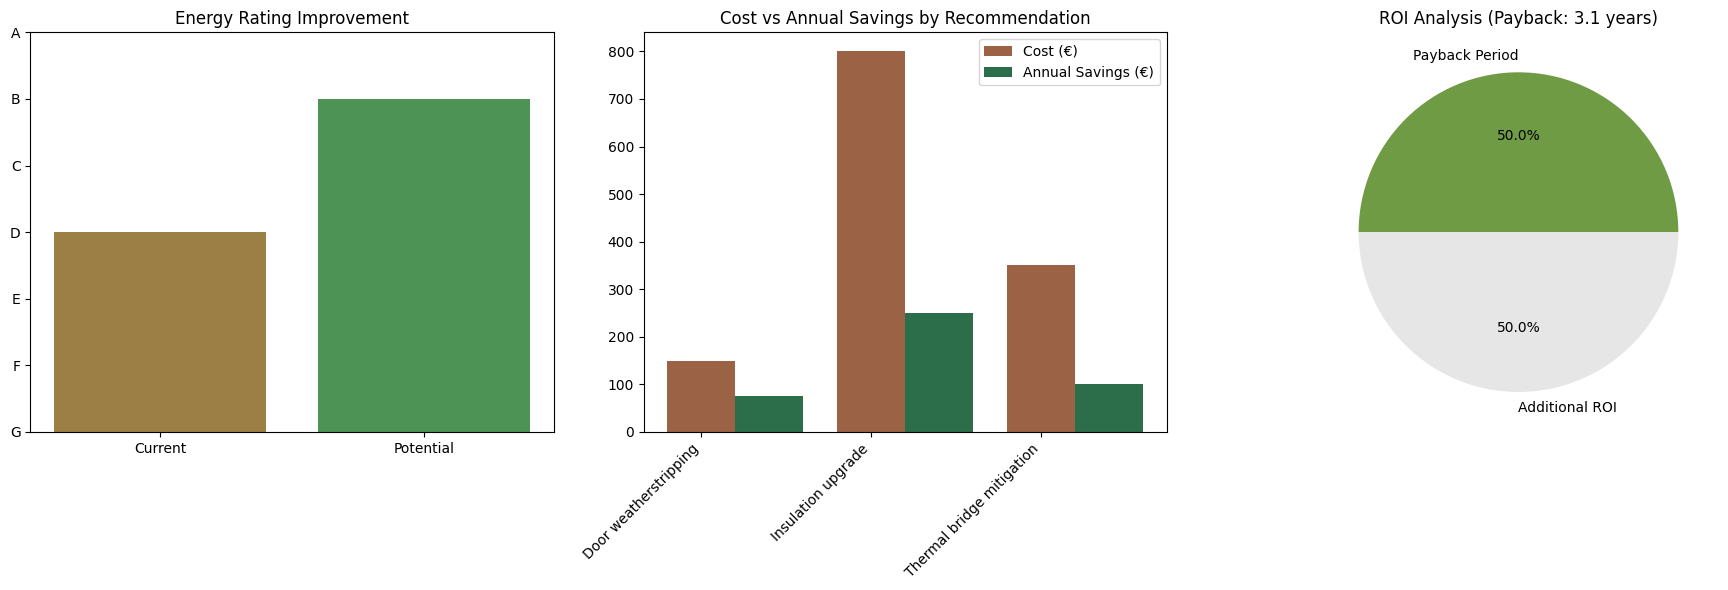

In [13]:
# This function would extract key data points from the analysis
def extract_metrics_from_report(report_text):
    """
    Extract key metrics from the report text for visualization.
    In a production system, this would parse the actual report text.
    
    Args:
        report_text: String containing the report markdown
        
    Returns:
        Dictionary with extracted metrics
    """
    # Placeholder function - in a real notebook, you would parse the report text
    # to extract actual metrics from the generated report
    
    # Sample data for demonstration
    metrics = {
        "current_rating": "D",
        "potential_rating": "B",
        "anomalies": [
            {"name": "Air leakage", "severity": "moderate"},
            {"name": "Insulation gap", "severity": "severe"},
            {"name": "Thermal bridge", "severity": "minor"}
        ],
        "recommendations": [
            {"name": "Door weatherstripping", "cost": 150, "savings": 75, "priority": "high"},
            {"name": "Insulation upgrade", "cost": 800, "savings": 250, "priority": "medium"},
            {"name": "Thermal bridge mitigation", "cost": 350, "savings": 100, "priority": "low"}
        ]
    }
    
    # Calculate derived metrics
    total_investment = sum(r["cost"] for r in metrics["recommendations"])
    annual_savings = sum(r["savings"] for r in metrics["recommendations"])
    
    # Calculate payback period with safety check
    if annual_savings > 0:
        payback_period = total_investment / annual_savings
    else:
        payback_period = float('inf')  # No payback if no savings
    
    # Add calculated metrics to the dictionary
    metrics.update({
        "total_investment": total_investment,
        "annual_savings": annual_savings,
        "payback_period": payback_period
    })
    
    return metrics

if 'final_report' in locals() and final_report:
    # Extract metrics
    metrics = extract_metrics_from_report(final_report)
    
    # Create visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Current vs Potential Rating
    labels = ['Current', 'Potential']
    values = [ord('G') - ord(metrics["current_rating"]), ord('G') - ord(metrics["potential_rating"])]
    colors = ['#9b7f45', '#4d9355']
    
    axes[0].bar(labels, values, color=colors)
    axes[0].set_title('Energy Rating Improvement')
    axes[0].set_ylim(0, 6)
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A'])
    
    # 2. Cost vs Savings
    recommendations = metrics["recommendations"]
    rec_names = [r["name"] for r in recommendations]
    costs = [r["cost"] for r in recommendations]
    savings = [r["savings"] for r in recommendations]
    
    x = range(len(rec_names))
    axes[1].bar(x, costs, width=0.4, label='Cost (€)', color='#9b6245', align='edge')
    axes[1].bar([i+0.4 for i in x], savings, width=0.4, label='Annual Savings (€)', color='#2c6e49', align='edge')
    axes[1].set_title('Cost vs Annual Savings by Recommendation')
    axes[1].set_xticks([i+0.2 for i in x])
    axes[1].set_xticklabels(rec_names, rotation=45, ha='right')
    axes[1].legend()
    
    # 3. Return on Investment
    payback = metrics["payback_period"]
    
    # Check if payback period is reasonable for visualization
    if payback != float('inf') and payback > 0 and payback < 50:  # Reasonable range for display
        # For pie chart, we show payback as % of a reasonable investment horizon (e.g., 20 years)
        investment_horizon = min(20, payback * 2)  # Cap at 20 years or 2x payback
        roi_data = [payback, max(0, investment_horizon - payback)]
        roi_labels = ['Payback Period', 'Additional ROI']
        
        axes[2].pie(roi_data, 
                 labels=roi_labels, 
                 colors=['#6f9b45', '#e6e6e6'],
                 autopct='%1.1f%%')
        axes[2].set_title(f'ROI Analysis (Payback: {payback:.1f} years)')
    else:
        # Alternative visualization when payback calculation isn't suitable for a pie chart
        axes[2].text(0.5, 0.5, 'ROI Analysis\nUnable to calculate meaningful\npayback period', 
                   horizontalalignment='center', verticalalignment='center', 
                   transform=axes[2].transAxes, fontsize=12)
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Format payback period for display
    if metrics["payback_period"] == float('inf'):
        payback_display = "No payback (insufficient savings)"
    else:
        payback_display = f"{metrics['payback_period']:.1f} years"
    
    # Display summary statistics
    summary_df = pd.DataFrame({
        'Metric': ['Total Investment', 'Annual Savings', 'Payback Period'],
        'Value': [f'€{metrics["total_investment"]}', f'€{metrics["annual_savings"]}/year', payback_display]
    })
    summary_df